# Regression Script LOO CV
## Random Forest

### Florian Beyer
### 2020-11-26
### V0.2

Quellen: 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153

In [1]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

from sklearn import preprocessing
import seaborn as sns

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

settings_sns = {'axes.facecolor': 'white',
                'axes.edgecolor': '0',
                'axes.grid': True,
                'axes.axisbelow': True,
                'axes.labelcolor': '.15',
                'figure.facecolor': 'white',
                'grid.color': '.8',
                'grid.linestyle': '--',
                'text.color': '0',
                'xtick.color': '0',
                'ytick.color': '0',
                'xtick.direction': 'in',
                'ytick.direction': 'in',
                'lines.solid_capstyle': 'round',
                'patch.edgecolor': 'w', 
                'patch.force_edgecolor': True,
                'image.cmap': 'Greys',
                'font.family': ['serif'],
                'font.sans-serif': ['Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif'],
                'xtick.bottom': True,
                'xtick.top': True,
                'ytick.left': True,
                'ytick.right': True,
                'axes.spines.left': True,
                'axes.spines.bottom': True,
                'axes.spines.right': True,
                'axes.spines.top': True}

In [50]:
# data input

# define a number of trees that should be used (default = 500)
est = 1000

randomState = 35

# the remote sensing image you want to classify
img_RS1 = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/raster/005_stacks/2019_LH_pre_stack_24bands.tif'
img_RS2 = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/raster/005_stacks/2019_LH_post_stack_24bands.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/vector/2020_Felddaten.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'P'


# save path, predicted image
prediction_map = 'N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/results/2020_LH_pre_rfr_'+attribute+'.tif'


# save path, trained model
#save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\PLSR_model.joblib'


In [55]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X

We have 50 training samples


In [56]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

The shape of our features is: (50, 24)
The number of Spectra is: 50
The number of bands is: 24


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

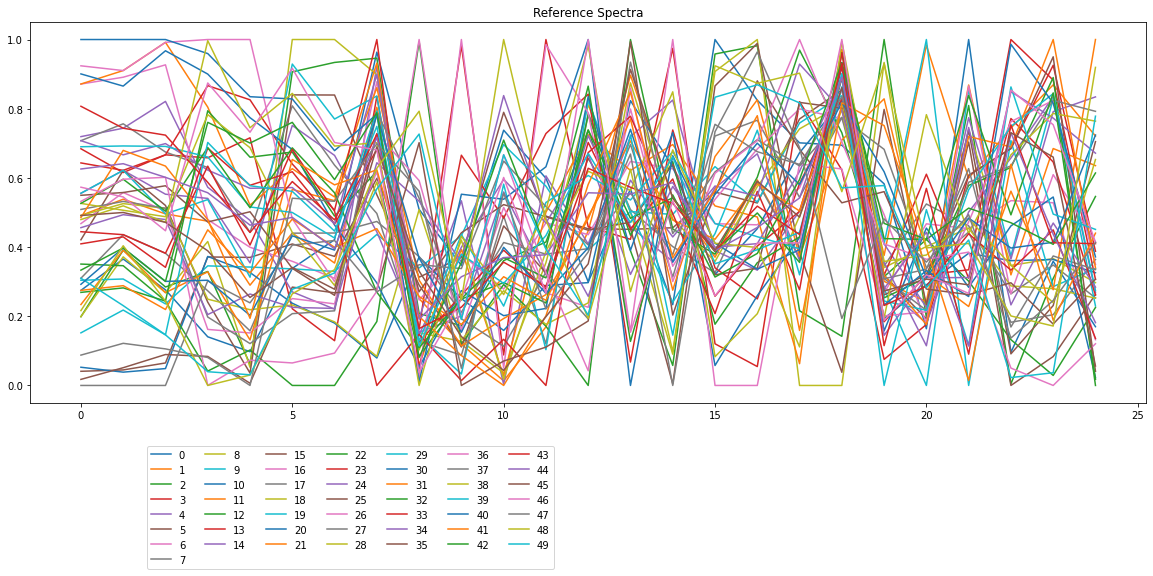

In [57]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

min_max_scaler = preprocessing.MinMaxScaler()

xscaled = min_max_scaler.fit_transform(features)
features_ = pd.DataFrame(xscaled)

features_.transpose().plot(figsize=(20,7))
plt.legend(bbox_to_anchor=(0.1, -0.1),loc='upper left', ncol=7)
plt.title('Reference Spectra')
plt.plot


In [58]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

print('Training Features Shape: ', features.shape)
print('Training Labels Shape: ', labels.shape)

Training Features Shape:  (50, 24)
Training Labels Shape:  (50,)


In [62]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=est,
                             n_jobs=-1, # using all cores
                             oob_score=True,
#                              random_state=randomState,
                             random_state=22,
                             verbose=0,
                             warm_start=False)
RFR.fit(features, labels);
y_c = RFR.predict(X)

y_cv = cross_val_predict(RFR, X, y, cv=X.shape[0], n_jobs=-1, verbose=2)

score_c = r2_score(y, y_c)
score_cv = r2_score(y, y_cv)

# Calculate mean squared error for calibration and cross validation
mse_c = mean_squared_error(y, y_c)
mse_cv = mean_squared_error(y, y_cv)


print('R2 calib: %5.3f'  % score_c)
print('R2 LOOCV: %5.3f'  % score_cv)
print('MSE calib: %5.3f' % mse_c)
print('MSE LOOCV: %5.3f' % mse_cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.6s


R2 calib: 0.834
R2 LOOCV: -0.208
MSE calib: 0.036
MSE LOOCV: 0.263


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.1s finished


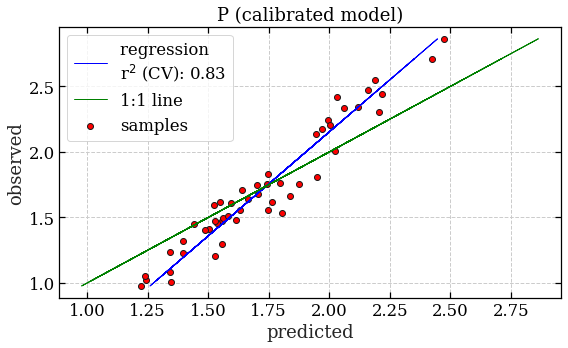

In [81]:
# quality of calibration model

# Fit a line to the CV vs response
z = np.polyfit(y, y_c, 1)
with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_c, y, c='red', edgecolors='k')
    #Plot the best fit line
    ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y, y, color='green', linewidth=1)
    plt.title(attribute + ' (calibrated model)')
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.legend(['regression \nr$^{2}$ (CV): '+str(round(score_c,2)),'1:1 line','samples'])

    #plt.savefig(validation_plot,bbox_inches='tight')

    plt.show()

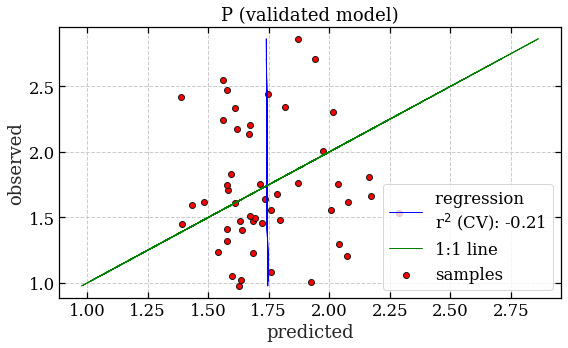

In [80]:
# quality of LOOCV validated model

# Fit a line to the CV vs response
z = np.polyfit(y, y_cv, 1)
with plt.style.context(('ggplot')):
    sns.set(rc=settings_sns, font_scale=1.5)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_cv, y, c='red', edgecolors='k')
    #Plot the best fit line
    ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
    #Plot the ideal 1:1 line
    ax.plot(y, y, color='green', linewidth=1)
    plt.title(attribute + ' (validated model)')
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.legend(['regression \nr$^{2}$ (CV): '+str(round(score_cv,2)),'1:1 line','samples'])

    #plt.savefig(validation_plot,bbox_inches='tight')

    plt.show()

In [64]:
# band importances
imp = {}
for i in range(len(RFR.feature_importances_)):
    importance = round(RFR.feature_importances_[i]*100,2)
    print('Band {}: {}'.format(i+1, importance))
    imp['Band{}'.format(i+1)] = importance

Band 1: 1.34
Band 2: 2.07
Band 3: 1.69
Band 4: 2.52
Band 5: 3.04
Band 6: 2.66
Band 7: 3.77
Band 8: 8.91
Band 9: 1.72
Band 10: 2.69
Band 11: 5.33
Band 12: 3.82
Band 13: 2.92
Band 14: 4.71
Band 15: 3.48
Band 16: 5.63
Band 17: 6.94
Band 18: 3.99
Band 19: 2.01
Band 20: 14.82
Band 21: 4.58
Band 22: 3.31
Band 23: 4.15
Band 24: 3.9


In [65]:
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))
sorted_imp 

{'Band20': 14.82,
 'Band8': 8.91,
 'Band17': 6.94,
 'Band16': 5.63,
 'Band11': 5.33,
 'Band14': 4.71,
 'Band21': 4.58,
 'Band23': 4.15,
 'Band18': 3.99,
 'Band24': 3.9,
 'Band12': 3.82,
 'Band7': 3.77,
 'Band15': 3.48,
 'Band22': 3.31,
 'Band5': 3.04,
 'Band13': 2.92,
 'Band10': 2.69,
 'Band6': 2.66,
 'Band4': 2.52,
 'Band2': 2.07,
 'Band19': 2.01,
 'Band9': 1.72,
 'Band3': 1.69,
 'Band1': 1.34}

In [66]:
# Calculate the absolute errors
errors = abs(y_cv - labels)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

mse = mean_squared_error(labels, y_cv)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))
print('RPD: {:.2f} | How often does RMSE of Prediction fit in the Standard Deviation of the samples'.format(np.std(labels)/np.sqrt(mse)))

'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE) / Accuracy: {:.2f}'.format(accuracy), '%.')
print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(labels, y_cv)))



-------------
n of the test data: 50
Mean of the variable: 1.72
Standard deviation of the variable: 0.47
-------------
Mean Absolute Error: 0.42
Mean squared error: 0.26
RMSE: 0.51
RPD: 0.91 | How often does RMSE of Prediction fit in the Standard Deviation of the samples
mean absolute percentage error (MAPE) / Accuracy: 74.08 %.
-------------
Coefficient of determination r²: -0.21


In [67]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (916, 165, 24) to (151140, 24)


In [68]:
prediction_ = RFR.predict(img_as_array)

In [69]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (916, 165)


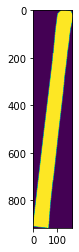

In [70]:
# generate mask image from red band
mask = np.copy(img[:,:,0])
mask[mask > 0.0] = 1.0 # all actual pixels have a value of 1.0

# plot mask

plt.imshow(mask)

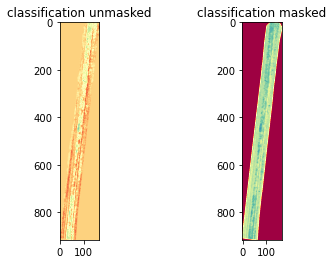

In [71]:
# mask classification an plot

prediction_ = prediction*mask

plt.subplot(121)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('classification unmasked')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral)
plt.title('classification masked')

plt.show()

In [72]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

prediction_.astype(np.float32)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction_)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: N:/Projekt_Wetscapes/Bearbeitung/2020_11_24_Lichtehagen/results/2020_LH_pre_rfr_P.tif


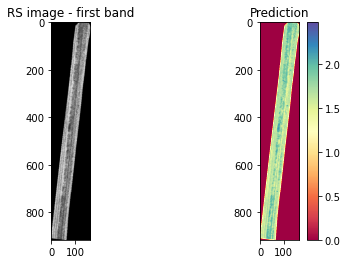

In [73]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction_, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title('Prediction')

plt.show()